<a href="https://colab.research.google.com/github/PabloViniciusSS/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
class Value:

  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [17]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L

Value(data=-8.0)

In [20]:
from graphviz import Digraph

def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'randir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
      uid = str(id(n))
      dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

      if n._op:

        dot.node(name = uid + n._op, label = n._op)

        dot.edge(uid + n._op, uid)

    for n1, n2 in edges:

      dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


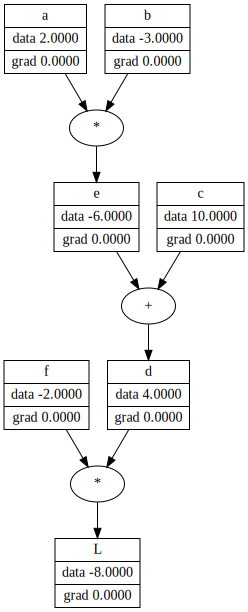

In [21]:
draw_dot(L)